# Model Training

## Imports

In [45]:
import pandas as pd
import numpy as np
from src.__00__paths import curated_data_dir, figures_dir, model_dir, docs_dir
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import joblib

## Load Dataframe

In [31]:
test_df = pd.read_csv(curated_data_dir / "test.csv")
test_df.head()

,Type,Size,Dept,IsHoliday,time_index,woy_sin,woy_cos,mon_sin,mon_cos,week_of_month,...,dist_easter_wk,dist_memorial_day_wk,dist_july4_wk,dist_labor_day_wk,dist_super_bowl_wk,is_black_friday_wk,is_thanksgiving_wk,is_xmas_peak_wk,is_back_to_school,Weekly_Sales
0,B,125833,17,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,4202.98
1,A,184109,41,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,307.50
2,A,203750,3,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,7245.43
3,C,39910,23,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,23.01
4,B,140167,4,False,115,0.937328,-0.348448,0.866025,-0.5,3,...,1,-6,0,0,0,1,1,1,0,19455.41


In [32]:
train_df = pd.read_csv(curated_data_dir / "train.csv")
train_df.head()

,Type,Size,Dept,IsHoliday,time_index,woy_sin,woy_cos,mon_sin,mon_cos,week_of_month,...,dist_easter_wk,dist_memorial_day_wk,dist_july4_wk,dist_labor_day_wk,dist_super_bowl_wk,is_black_friday_wk,is_thanksgiving_wk,is_xmas_peak_wk,is_back_to_school,Weekly_Sales
0,A,151315,1,False,0,0.566372,0.82415,0.866025,0.5,1,...,0,0,0,0,-1,1,1,1,0,24924.50
1,B,125833,97,False,0,0.566372,0.82415,0.866025,0.5,1,...,0,0,0,0,-1,1,1,1,0,668.48
2,B,125833,85,False,0,0.566372,0.82415,0.866025,0.5,1,...,0,0,0,0,-1,1,1,1,0,693.87
3,A,155078,80,False,0,0.566372,0.82415,0.866025,0.5,1,...,0,0,0,0,-1,1,1,1,0,8654.60
4,B,125833,55,False,0,0.566372,0.82415,0.866025,0.5,1,...,0,0,0,0,-1,1,1,1,0,11123.56


## Split Features & Labels

In [33]:
x_train = train_df.drop(columns=["Weekly_Sales"])
y_train = train_df["Weekly_Sales"]
x_test = test_df.drop(columns=["Weekly_Sales"])
y_test = test_df["Weekly_Sales"]

## One Hot Encoding

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import pandas as pd

# One-hot encode separately
x_train = pd.get_dummies(x_train, columns=["Type"], prefix="Type")
x_test = pd.get_dummies(x_test, columns=["Type"], prefix="Type")

# Align columns in case any category was missing in either set
x_train, x_test = x_train.align(x_test, join="left", axis=1, fill_value=0)
# --- Define model and search space ---
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

## Hyperparameter Tuning

In [36]:
# --- Define model and search space ---
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}

# --- Randomized Search ---
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
# Fit on training data
random_search.fit(x_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END max_depth=48, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   0.0s
[CV] END max_depth=48, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   0.0s
[CV] END max_depth=48, max_features=auto, min_samples_leaf=8, min_samples_split=6, n_estimators=120; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=251; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=251; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=9, n_estimators=251; total time=   0.0s
[CV] END max_depth=12, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=187; total time=  22.4s
[CV] END max_depth=12, max_features=sqrt, min_samples_leaf=5, min_samples_split=3, n_estimators=187

/Users/yassientawfik/Documents/Career/Projects/PythonVenv/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=39, max_features=sqrt, min_samples_leaf=2, min_samples_split=9, n_estimators=287; total time=  57.7s
[CV] END max_depth=39, max_features=sqrt, min_samples_leaf=2, min_samples_split=9, n_estimators=287; total time=  58.7s
[CV] END max_depth=36, max_features=log2, min_samples_leaf=3, min_samples_split=5, n_estimators=154; total time=  28.1s
[CV] END max_depth=18, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=188; total time=  27.3s
[CV] END max_depth=18, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=188; total time=  27.3s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=7, min_samples_split=5, n_estimators=107; total time=   9.2s
[CV] END max_depth=11, max_features=log2, min_samples_leaf=7, min_samples_split=5, n_estimators=107; total time=   9.6s
[CV] END max_depth=39, max_features=sqrt, min_samples_leaf=2, min_samples_split=9, n_estimators=287; total time=  55.1s
[CV] END max_depth=18, max_features=log2

/Users/yassientawfik/Documents/Career/Projects/PythonVenv/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/yassientawfik/Documents/Career/Projects/PythonVenv/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/yassientawfik/Documents/Career/Projects/PythonVenv/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/yassientawfik/Documen

Best Parameters: {'max_depth': 38, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 170}


## Model Training

In [37]:
best_rf = RandomForestRegressor(
    max_depth=38,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=170,
    n_jobs=-1,
    random_state=42
)
best_rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=38, max_features='log2', n_estimators=170,
                      n_jobs=-1, random_state=42)

## Save the Model

In [46]:
# Save the model
joblib.dump(best_rf, model_dir / "best_random_forest_model.joblib")
print(f"Model saved to {'/'.join((model_dir / "best_random_forest_model.joblib").parts[-3:])}")

Model saved to output/models/best_random_forest_model.joblib


## Predict and Evaluate

In [43]:
from sklearn.metrics import mean_absolute_error

# Predictions
y_pred = rf.predict(x_test)

# MAE
mae = mean_absolute_error(y_test, y_pred)
avg_sales = y_test.mean()
relative_error = mae / avg_sales * 100

# Holiday weights: 5 for holidays, 1 otherwise
weights = test_df["IsHoliday"].apply(lambda x: 5 if x else 1)
wmae = (weights * abs(y_test - y_pred)).sum() / weights.sum()

# Print results
print(f"MAE: {mae:.2f}")
print(f"Average Weekly Sales: ${avg_sales:.2f}")
print(f"Relative MAE: {relative_error:.2f}%")
print(f"WMAE: {wmae:.2f}")

MAE: 1657.73
Average Weekly Sales: $15785.37
Relative MAE: 10.50%
WMAE: 1685.57


## Save Text File

In [51]:
# Save to text file
with open(docs_dir / "evaluation_results.txt", "w") as f:
    best_params_text = f"Params: {random_search.best_params_}"
    f.write(best_params_text + "\n")
    f.write("=" * len(best_params_text) + "\n")
    f.write(f"MAE: {mae:.2f}\n")
    f.write(f"Average Weekly Sales: ${avg_sales:.2f}\n")
    f.write(f"Relative MAE: {relative_error:.2f}%\n")
    f.write(f"WMAE: {wmae:.2f}\n")

print(f"Evaluation results saved to {'/'.join((docs_dir / 'evaluation_results.txt').parts[-3:])}")

Evaluation results saved to output/docs/evaluation_results.txt


## Visualization

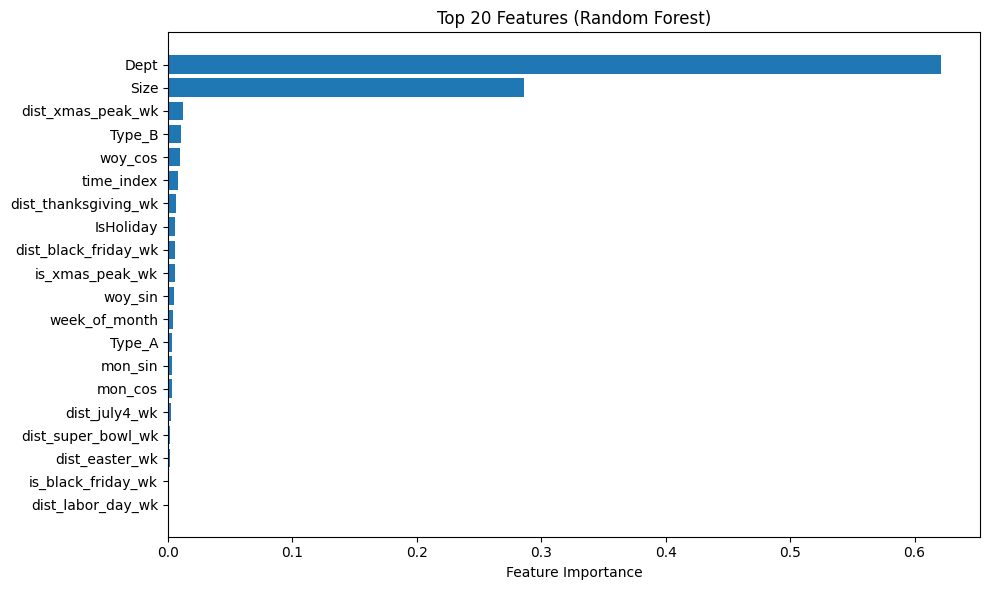

In [52]:
importances = rf.feature_importances_
features = x_train.columns
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), features[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features (Random Forest)")
plt.tight_layout()

# Save the figure before showing it
plt.savefig(figures_dir / "feature_importance.png", dpi=300)

plt.show()

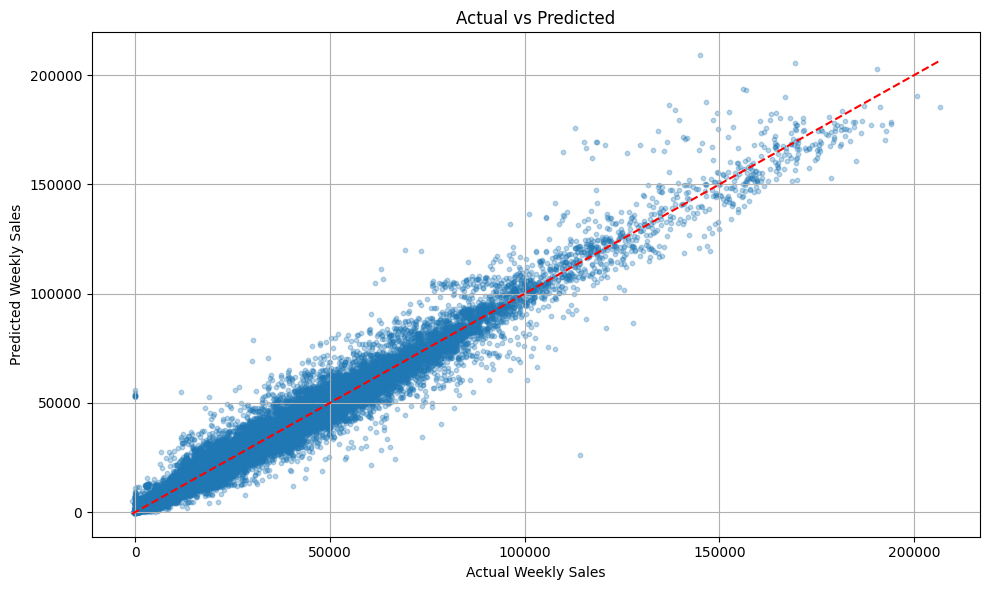

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig(figures_dir / "actual_predicted.png", dpi=300)

plt.show()